In [3]:
!pip install transformers


     |████████████████████████████████| 2.3MB 8.3MB/s 
     |████████████████████████████████| 901kB 46.2MB/s 
     |████████████████████████████████| 3.3MB 45.1MB/s 


In [1]:
# Load Huggingface transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast
# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
# And pandas for data import + sklearn because you allways need sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Concatenate
import seaborn as sns
import matplotlib.pyplot as plt
import numpy
from keras.layers.pooling import GlobalAveragePooling1D
import torch

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#use cleaned data
dataset=pd.DataFrame()
dataset = pd.read_pickle('dataset_prepro.pickle')

In [3]:
label_list = [ "Electricity",
        "Storm",
        "WaterDamage",
        "Other_DamageType",
        "CracksAndTears",
        "GlassBreakage",
        "Collision",
        "Burglary",
        "Fire_Smoke_Explosion",
        "Theft",
        "Environment_OilFuel",
        "Flooding",]
dataset = dataset[dataset["labels.damage_type"].isin(label_list)]

In [4]:
n=500
dataset=dataset.set_index(['language', 'mail_content','labels.assignment_type','labels.case_type','labels.sub_case_type','labels.damage_type','attachments_filename'])['attachments_content'].str.split().apply(
               lambda x: pd.Series([' '.join(x[i:i+n]) for i in range(0, len(x), n)])
            ).stack().reset_index().drop('level_7', 1)
dataset.columns = [*dataset.columns[:-1], 'attachments_content']

In [5]:
#SPLIT NL AND FR
dataset_nl=dataset.loc[dataset['language']=='nl_BE']
dataset_fr=dataset.loc[dataset['language']=='fr_BE']
dataset_nl.drop('language', axis=1, inplace=True) 
dataset_fr.drop('language', axis=1, inplace=True)

/Users/alechantson/Library/Python/3.7/lib/python/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


NameError: ignored

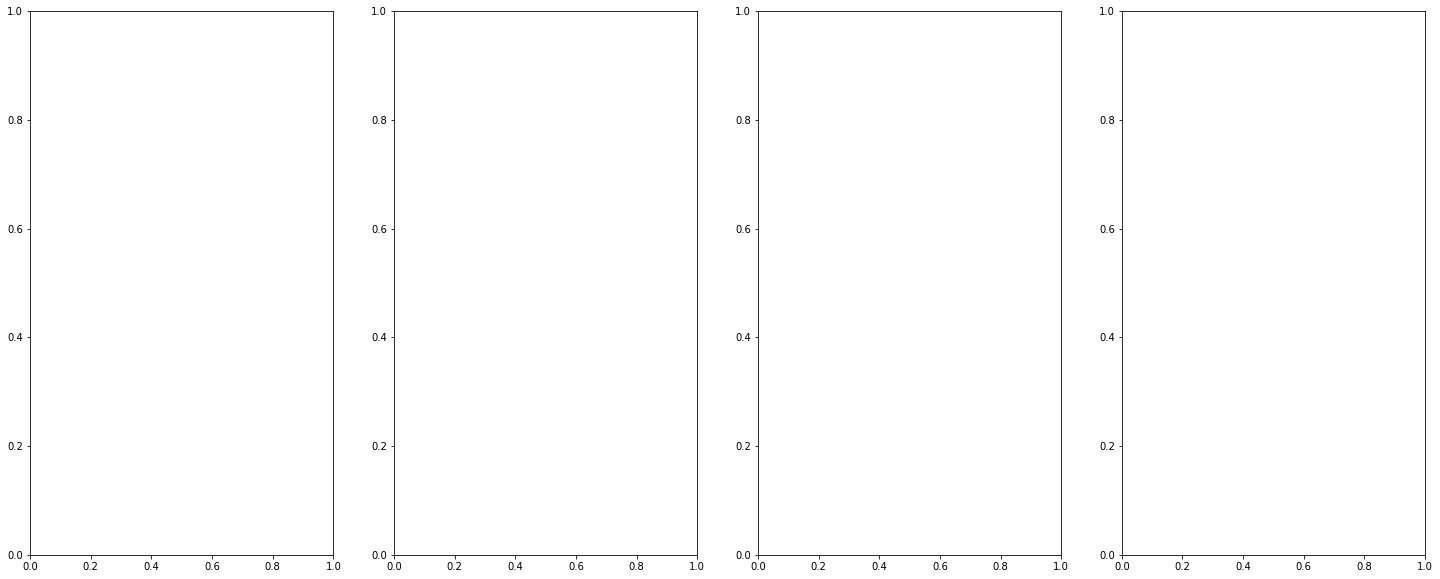

In [9]:
fig, ax = plt.subplots(1,4)
fig.set_figwidth(25)
fig.set_figheight(10)
sns.countplot(x='labels.case_type',data=y_nl,ax=ax[0])
sns.countplot(x='labels.sub_case_type',data=y_nl,ax=ax[1])
sns.countplot(x='labels.damage_type',data=y_nl,ax=ax[2])
sns.countplot(x='labels.assignment_type',data=y_nl,ax=ax[3])

In [ ]:
dataset_nl

In [6]:
y_nl=dataset_nl[['labels.case_type','labels.sub_case_type','labels.damage_type','labels.assignment_type']]
X_nl=dataset_nl.drop(['labels.case_type','labels.sub_case_type','labels.damage_type','labels.assignment_type'], axis=1)

In [7]:
X_train_nl, X_test_nl, y_train_nl, y_test_nl = train_test_split(X_nl,y_nl, test_size = 0.20, random_state=0)
print(X_train_nl.shape,y_train_nl.shape)
print(X_test_nl.shape,y_test_nl.shape)

(5640, 3) (5640, 4)
(1411, 3) (1411, 4)


In [8]:
# Name of the BERT model to use
model_name = 'wietsedv/bert-base-dutch-cased'
# Max length of tokens
max_length = 500
# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False
# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)
# Load the Transformers BERT model
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at wietsedv/bert-base-dutch-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at wietsedv/bert-base-dutch-cased and are newly initialized: ['bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def tokenize_content(text):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text))

In [10]:
print(dataset.mail_content.str.split().str.len().max())
print(dataset.attachments_filename.str.split().str.len().max())
print(dataset.attachments_content.str.split().str.len().max())

148
366
500


In [11]:
X_train_nl_mc=X_train_nl['mail_content'].apply(tokenize_content)
X_train_nl_af=X_train_nl['attachments_filename'].apply(tokenize_content)
X_train_nl_ac=X_train_nl['attachments_content'].apply(tokenize_content)
X_test_nl_mc=X_test_nl['mail_content'].apply(tokenize_content)
X_test_nl_af=X_test_nl['attachments_filename'].apply(tokenize_content)
X_test_nl_ac=X_test_nl['attachments_content'].apply(tokenize_content)

Token indices sequence length is longer than the specified maximum sequence length for this model (738 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [12]:
#One-hot multi output
y1_train=pd.DataFrame(columns=pd.get_dummies(y_nl[['labels.assignment_type']]).columns)
y1_test=pd.DataFrame(columns=pd.get_dummies(y_nl[['labels.assignment_type']]).columns)
y2_train=pd.DataFrame(columns=pd.get_dummies(y_nl[['labels.case_type']]).columns)
y2_test=pd.DataFrame(columns=pd.get_dummies(y_nl[['labels.case_type']]).columns)
y3_train=pd.DataFrame(columns=pd.get_dummies(y_nl[['labels.sub_case_type']]).columns)
y3_test=pd.DataFrame(columns=pd.get_dummies(y_nl[['labels.sub_case_type']]).columns)
y4_train=pd.DataFrame(columns=pd.get_dummies(y_nl[['labels.damage_type']]).columns)
y4_test=pd.DataFrame(columns=pd.get_dummies(y_nl[['labels.damage_type']]).columns)

y1_train=y1_train.combine_first(pd.get_dummies(y_train_nl[['labels.assignment_type']])).fillna(0)
print('Shape of label tensor Y1 Train:', y1_train.shape)
y1_test=y1_test.combine_first(pd.get_dummies(y_test_nl[['labels.assignment_type']])).fillna(0)
print('Shape of label tensor Y1 Test:', y1_test.shape)

y2_train=y2_train.combine_first(pd.get_dummies(y_train_nl[['labels.case_type']])).fillna(0)
print('Shape of label tensor Y2 Train:', y2_train.shape)
y2_test=y2_test.combine_first(pd.get_dummies(y_test_nl[['labels.case_type']])).fillna(0)
print('Shape of label tensor Y2 Test:', y2_test.shape)

y3_train=y3_train.combine_first(pd.get_dummies(y_train_nl[['labels.sub_case_type']])).fillna(0)
print('Shape of label tensor Y3 Train:', y3_train.shape)
y3_test=y3_test.combine_first(pd.get_dummies(y_test_nl[['labels.sub_case_type']])).fillna(0)
print('Shape of label tensor Y3 Test:', y3_test.shape)

y4_train=y4_train.combine_first(pd.get_dummies(y_train_nl[['labels.damage_type']])).fillna(0)
print('Shape of label tensor Y4 Train:', y4_train.shape)
y4_test=y4_test.combine_first(pd.get_dummies(y_test_nl[['labels.damage_type']])).fillna(0)
print('Shape of label tensor Y4 Test:', y4_test.shape)

Shape of label tensor Y1 Train: (5640, 2)
Shape of label tensor Y1 Test: (1411, 2)
Shape of label tensor Y2 Train: (5640, 2)
Shape of label tensor Y2 Test: (1411, 2)
Shape of label tensor Y3 Train: (5640, 10)
Shape of label tensor Y3 Test: (1411, 10)
Shape of label tensor Y4 Train: (5640, 12)
Shape of label tensor Y4 Test: (1411, 12)


In [17]:
print(numpy.version.version)

1.19.5


In [23]:
tf.__version__

'2.5.0'

In [15]:
# # Load the MainLayer
bert = transformer_model.layers[0]
# #Optimizer
# opt = tf.keras.optimizers.Adam(lr=0.0001)
# # Early stopping
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=35)

#checkpoint
# checkpoint_path='/content/drive/MyDrive/LSTM_bestmodel.h5'
# mc=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True)

#Model
input_mc = Input(shape=(400),dtype='int32')
input_af = Input(shape=(200),dtype='int32')
input_ac = Input(shape=(500),dtype='int32')

bert_model_mc=bert({'input_ids': input_mc})[1]
bert_model_af=bert({'input_ids': input_af})[1]
bert_model_ac=bert({'input_ids': input_ac})[1]

dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output_mc = dropout(bert_model_mc, training=False)
pooled_output_af = dropout(bert_model_af, training=False)
pooled_output_ac = dropout(bert_model_ac, training=False)

concat_layer = Concatenate()([pooled_output_mc, pooled_output_af,pooled_output_ac])

o1=Dense(units=2, kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='assignment_type')(concat_layer)
o2=Dense(units=2, kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='case_type')(concat_layer)
o3=Dense(units=10, kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='sub_case_type')(concat_layer)
o4=Dense(units=12, kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='damage_type')(concat_layer)

epochs = 400
batch_size = 128

model = Model(inputs=[input_mc,input_af,input_ac], outputs=[o1, o2, o3, o4])
model.summary()
# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# history = model.fit([X_train_nl_mc,X_train_nl_af,X_train_nl_ac],[y1_train,y2_train,y3_train,y4_train],epochs=epochs,experimental_run_tf_function=False, batch_size=batch_size,validation_split=0.3,callbacks=[es,mc])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          multiple             109137408   input_7[0][0]                    
                                                                 input_8[0][0]                

In [23]:
#######################################
### ------- Build the model ------- ###
# TF Keras documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model
# Load the MainLayer
bert = transformer_model.layers[0]
# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}
# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)
# Then build your model output
issue = Dense(units=500, kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='issue')(pooled_output)
product = Dense(units=500, kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='product')(pooled_output)
outputs = {'issue': issue, 'product': product}
# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel_MultiClass')
# Take a look at the model
model.summary()

TypeError: Cannot convert a symbolic Keras input/output to a numpy array. This error may indicate that you're trying to pass a symbolic value to a NumPy call, which is not supported. Or, you may be trying to pass Keras symbolic inputs/outputs to a TF API that does not register dispatching, preventing Keras from automatically converting the API call to a lambda layer in the Functional Model.